# AnomalyToolKit: Production check - Batch application

This text explains how to use the production checks in the AnomalyToolKit for batch mode and offline use. 

# Loading modules

Loading the modules we need throughout the notebook:

In [1]:
import numpy 
import pandas
import os
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..')

# Loading data

As an example, we use data from a sensor ageing data repository.  (v1.0.2) [[Zenodo]](https://doi.org/10.5281/zenodo.3229195). Make sure you have downloaded the file  `potential_rowB.zip`, unzip the contents into a folder of your liking. Then, make sure the folder path in the following cell matches the folder you have chosen:

In [2]:
strFolder = 'C:/G/data/sensorageing/potential_rowB/'

To enable use of the productivity check, we load all data in a string format. This avoids automatic conversions which may mask some issues with the data.

In [3]:
filename  = Path(strFolder+'rowB_potential_day332.csv')
dfStrData = pandas.read_csv(filepath_or_buffer=filename,delimiter  =';',header =0,dtype=str)
dfStrData.head()

date_time         T1b         T2b         T3b         T4b  \
0  2017.08.31 00:00:01   30.400000    2.700000   -9.300000   48.599998   
1  2017.08.31 00:00:02   30.300001    2.700000   -9.300000   48.599998   
2  2017.08.31 00:00:03   30.400000    2.600000   -9.400000   48.599998   
3  2017.08.31 00:00:04   30.400000    2.700000   -9.400000   48.599998   
4  2017.08.31 00:00:05   30.300001    2.700000   -9.300000   48.599998   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

# DateTimeCheck

## DateTimeCheck: Setup

We set up an one instance of the class `datetimecheck` in the `production` module and call it `CheckDT`. We define it so that the expected datetime format matches the `date_time` variable in the first 5 lines shown above: 

In [4]:
from basic.production import datetimecheck
CheckDT = datetimecheck(DateTimeFormat='%Y.%m.%d %H:%M:%S')

## DateTimeCheck: Batch mode application

### DateTimeCheck: Applying it once in batch mode

The syntax for to use this check in offline mode is practically the same as for the online mode. We can simply apply the check to the `date_time` column of the data frame. We are also checking how much time we need to do this for the whole data set:

In [5]:
start_time = time.time()
CheckResult , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.247347354888916 seconds ---


Not everyone works with `pandas` so we can imagine that we want to apply it to a list instead:

In [6]:
lstDateTime = dfStrData['date_time'].values

start_time = time.time()
CheckResult , DateTime =  CheckDT(DateTimeEntry=lstDateTime)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.3154988288879395 seconds ---


In [7]:
lstDateTime = dfStrData['date_time'].values

start_time = time.time()
CheckResult , DateTime =  CheckDT(DateTimeEntry=lstDateTime)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2994542121887207 seconds ---


or to a `numpy.array`:

In [8]:
aDateTime = numpy.array(dfStrData['date_time'])

start_time = time.time()
CheckResult , DateTime =  CheckDT(DateTimeEntry=aDateTime)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2593863010406494 seconds ---


We get the same result with every case with about the same computational requirements.

### DateTimeCheck: Applying it in a sequencing batch mode

In the above, we applied the test to the data from a single day (day 42). We will now apply the test for the first 11 days. For this, we will apply a for loop that sequentially loads the data from a single day, starting at day 1 and ending with day 11.

**Note on efficiency**

For a large data set, we may want to apply the check to all data. Loading the complete data set is not recommended however. In general, there is some trade-off between loading larger chunks of data in memory, which minimizes the number of times data needs to be loaded and the check needs to be executed, and loading smaller chuncks of data in memory, which minimizes the memory usage. The optimal trade-off depends on several factors. This includes factors concering your computer system as well as factors related to the way you obtain your data (e.g., the responsiveness of a database query). Here, we will assume that the data is separated optimally in the provided data files. Each file has the data of one day and we assume that this is the optimal size of a chunk of data.

In [9]:
nDay = 11

x = numpy.empty((0,), dtype=[('DateTime', numpy.datetime64),('CheckDateTime',numpy.bool_)])
dfCheckDT = pandas.DataFrame(x)

for day in range(nDay):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filepath)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        dfCheckDTadd = pandas.DataFrame(columns=['DateTime','CheckDateTime'])
        dfCheckDTadd['DateTime'] = DateTime
        dfCheckDTadd['CheckDateTime'] = CheckResult0
        dfCheckDT = pandas.concat([dfCheckDT, dfCheckDTadd],ignore_index=True)

C:\G\data\sensorageing\potential_rowB\rowB_potential_day001.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day002.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day003.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day004.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day005.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day006.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day007.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day008.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day009.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day010.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day011.csv


**Visualization**

Next we visualize the result by showing the True/False result as 1/0 values as a function of the sample index

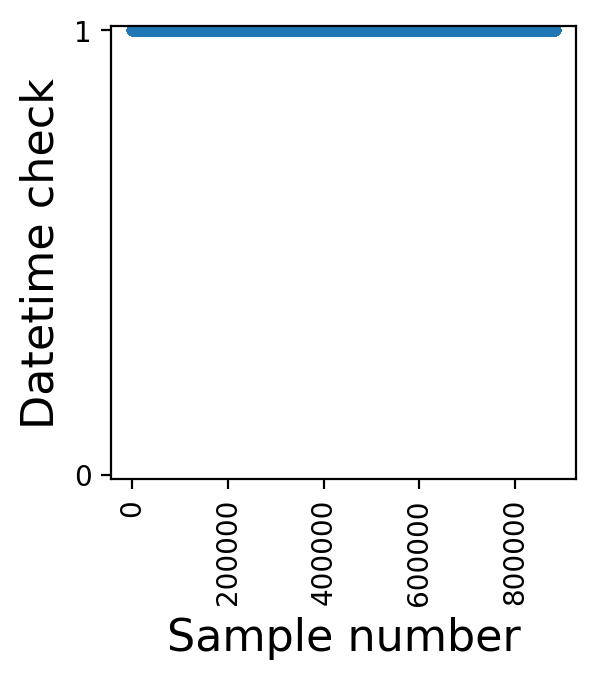

In [10]:
NumberOfSamples = len(dfCheckDT)
x = numpy.arange(NumberOfSamples);
y = dfCheckDT['CheckDateTime'];

fig = plt.figure(figsize=(3,3),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('Datetime check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1])
plt.xticks(rotation=90);

A plot like this is likely not very useful for practical purposes. Imagine there is a day in which the sensor did not produce any (valid) timestamps. The plot above will not reveal which day that is. For this reason, the *production* module in the *AnomalyToolKit* is equipped with a *aggregate* feature, which is demonstrated below. Before doing that, we demonstrate the application of *numericcheck*.

# NumericCheck

## NumericCheck: Setup

We now set up a check to test if the sensor readings can be interpreted as numeric values. The checks are instances of the class *numericcheck* in the same module (*production*).

In [11]:
from basic.production import numericcheck
CheckNUM = numericcheck(NumberFormat='float')

## NumericCheck: Batch mode application

### NumericCheck: Applying it once in batch mode

The syntax for to use this check in offline mode is practically the same as for the online mode. We can simply apply the check to the *T1a* column of the data frame. We are also checking how much time we need to do this for the whole data set:

In [12]:
start_time = time.time()
CheckResult , Number = CheckNUM(NumberEntry=dfStrData['T1b'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.12733817100524902 seconds ---


As with the DateTimecheck, we can apply it to a list or to a numpy array with similar computational performance:

In [13]:
lstT1b = dfStrData['T1b'].values
start_time = time.time()
CheckResult , Number = CheckNUM(NumberEntry=lstT1b)
print("--- %s seconds ---" % (time.time() - start_time))

aT1b = numpy.array(dfStrData['T1b'])
start_time = time.time()
CheckResult , Number = CheckNUM(NumberEntry=aT1b)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1113278865814209 seconds ---
--- 0.11430525779724121 seconds ---


### NumericCheck: Applying it in a sequencing batch mode

As with the *datetimecheck*, we can apply the *numericcheck* in a sequencing batch mode to trade off memory requirements against computational requirements. We apply this to the data produced by sensor T1b for the first 11 days.

In [14]:
nDay = 11

x = numpy.empty((0,), dtype=[('CheckSenssorT1b',numpy.bool_)])
dfCheckNUM = pandas.DataFrame(x)

for day in range(nDay):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filepath)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult1b , Number1b = CheckNUM(NumberEntry=dfStrData['T1b'])
        dfCheckNUMadd = pandas.DataFrame(columns=['CheckSenssorT1b'])
        dfCheckNUMadd['CheckSenssorT1b'] = CheckResult1b
        dfCheckNUM = pandas.concat([dfCheckNUM, dfCheckNUMadd],ignore_index=True,sort=False)

C:\G\data\sensorageing\potential_rowB\rowB_potential_day001.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day002.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day003.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day004.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day005.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day006.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day007.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day008.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day009.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day010.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day011.csv


**Visualization**

Next we visualize the result by showing the True/False result as 1/0 values as a function of the sample index. As with the datetimecheck, this is not the most useful visualization. The *aggregate* feature shown below fixes that. 

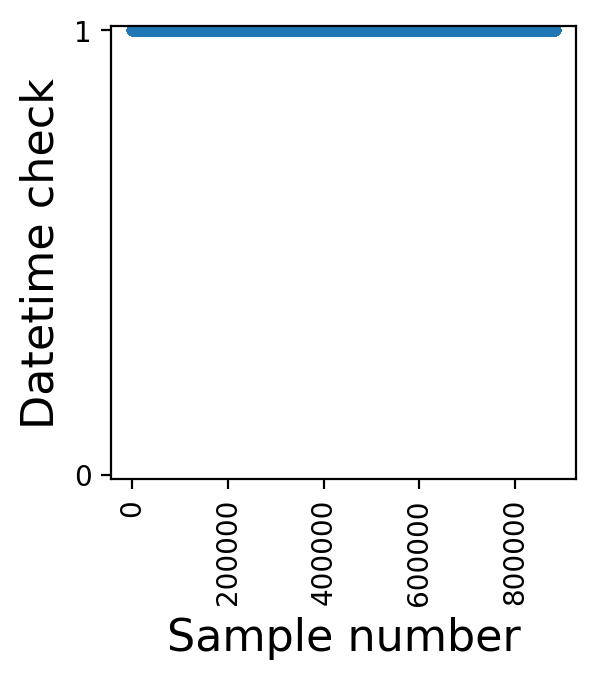

In [15]:
NumberOfSamples = len(dfCheckNUM)
x = numpy.arange(NumberOfSamples);
y = dfCheckNUM['CheckSenssorT1b'];

fig = plt.figure(figsize=(3,3),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('Datetime check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);
plt.xticks(rotation=90);

# DateTimeCheck: Aggregation

The *aggregator* feature identifies the number of data points collected within consecutive time windows that match the intended format. The time window is specified as an integer number of hours, which has to be a divisor of 24 (permitted values: 1, 2, 3, 4, 6, 8, 12, 24, default: 24). The next piece of code specifies aggregation in periods of 3 hours. We also indicate the expected number of samples in this window, which is optional:

In [16]:
from basic.production import aggregate

TimeWindow = 3 ;
agg1 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

The next piece of code executes 5 checks for the data from day 42: one instance of datetimecheck and four instances of  numericcheck, one for each sensor:

In [17]:
filename = 'rowB_potential_day332.csv'
filepath = Path(strFolder+filename)
dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)

CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
CheckResult1 , Number1 =  CheckNUM(NumberEntry=dfStrData['T1b'])
CheckResult2 , Number2 =  CheckNUM(NumberEntry=dfStrData['T2b'])
CheckResult3 , Number3 =  CheckNUM(NumberEntry=dfStrData['T3b'])
CheckResult4 , Number4 =  CheckNUM(NumberEntry=dfStrData['T4b'])


The *aggregate* feature requires the use of a pandas dataframe and requires that this dataframe contains:

* A column named `DateTime` which contains the datetime (pandas timestamp)

* A column named `DateTimeCheck` which contains the datetime check result (boolean)

* Any number of additional columns which contain additional check results (boolean)

The next piece of code prepares the data to match this format:

In [18]:
dfCheckDTNUMadd = pandas.DataFrame(columns=['DateTime','DateTimeCheck','CheckSenssorT1b','CheckSenssorT2b','CheckSenssorT3b','CheckSenssorT4b'])
dfCheckDTNUMadd['DateTime'] = DateTime
dfCheckDTNUMadd['DateTimeCheck'] = CheckResult0
dfCheckDTNUMadd['CheckSenssorT1b'] = CheckResult1
dfCheckDTNUMadd['CheckSenssorT2b'] = CheckResult2
dfCheckDTNUMadd['CheckSenssorT3b'] = CheckResult3
dfCheckDTNUMadd['CheckSenssorT4b'] = CheckResult4

This dataframe is passed in by calling the instance of *aggregate*. By doing so, we keep track of two numbers: (a) the number of samples with correct timestamp in a given time window and the number of samples with correct timestamp and a positive other check for every check in the dataframe. The call spits out the updated list of numbers:

In [19]:
CountCheckDateTime, CountAll = agg1(dfCheckDTNUMadd)
print(CountCheckDateTime)
print(CountAll)

Date        TimeSlot
2017-08-31  0           10194.0
            1           10187.0
            2           10188.0
            3           10182.0
            4           10182.0
            5           10183.0
            6           10182.0
            7           10186.0
dtype: float64
Date        TimeSlot
2017-08-31  0           10194.0
            1           10187.0
            2           10188.0
            3           10182.0
            4           10182.0
            5           10183.0
            6           10182.0
            7           10186.0
dtype: float64


One can see that both counts are the same for every time slot, meaning that every row in the dataframe with correct timestamp also has a correctly specified number for every sensor reading. In order to enable easy updating of these counts (see example below), the obtained counts are also memorized internally:

In [20]:
print(agg1.iCountCheckDateTime)
print(agg1.iCountAll)

Date        TimeSlot
2017-08-31  0           10194.0
            1           10187.0
            2           10188.0
            3           10182.0
            4           10182.0
            5           10183.0
            6           10182.0
            7           10186.0
dtype: float64
Date        TimeSlot
2017-08-31  0           10194.0
            1           10187.0
            2           10188.0
            3           10182.0
            4           10182.0
            5           10183.0
            6           10182.0
            7           10186.0
dtype: float64


Both numbers are visualized with a barchart next. The outputs *fig* and *ax* are the figure and axes objects, which can be used to modify the chart further.

C:\ProgramData\Anaconda3_1\envs\ATK\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


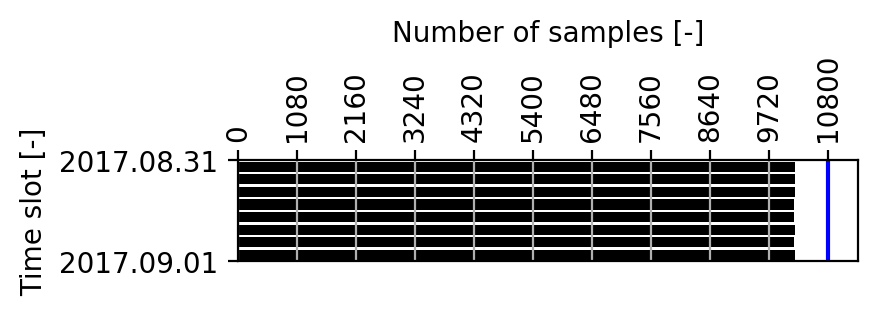

In [21]:
fig, ax = agg1.chartbar()

Because both numbers are the same, the bars for the first counts (datetime check only, red color) are masked by the second counts (all checks, black color) so it's easy to see that all produces samples with a correct timestamp also have correct sensor readings. One can also see that the number of produced samples is about 95% of the expected number. 

The next piece of code loops over the last 31 days of the data set and iteratively updates the aggregated numbers. Note that we do not store the individual checks, only the aggregated ones. This saves us some memory. Note also that we create a new *aggregate* object for two reasons: (a) otherwise we could add the counts from day 42 two times and (b) we want to use a different time window, 8 hours in this case:

In [22]:
iDayStart = 700
iDayEnd = 731
TimeWindow = 8

from basic.production import aggregate
agg2 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filepath)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)        
        
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number1 =  CheckNUM(NumberEntry=dfStrData['T1b'])
        CheckResult2 , Number2 =  CheckNUM(NumberEntry=dfStrData['T2b'])
        CheckResult3 , Number3 =  CheckNUM(NumberEntry=dfStrData['T3b'])
        CheckResult4 , Number4 =  CheckNUM(NumberEntry=dfStrData['T4b'])
        
        dfCheckDTNUMadd = pandas.DataFrame(columns=['DateTime','DateTimeCheck','CheckSenssorT1b','CheckSenssorT2b','CheckSenssorT3b','CheckSenssorT4b'])
        dfCheckDTNUMadd['DateTime'] = DateTime
        dfCheckDTNUMadd['DateTimeCheck'] = CheckResult0
        dfCheckDTNUMadd['CheckSenssorT1b'] = CheckResult1
        dfCheckDTNUMadd['CheckSenssorT2b'] = CheckResult2
        dfCheckDTNUMadd['CheckSenssorT3b'] = CheckResult3
        dfCheckDTNUMadd['CheckSenssorT4b'] = CheckResult4
        
        agg2(dfCheckDTNUMadd)

C:\G\data\sensorageing\potential_rowB\rowB_potential_day701.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day702.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day703.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day704.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day705.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day706.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day707.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day708.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day709.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day710.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day711.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day712.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day713.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day714.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day715.csv
C:\G\data\sensorageing\potential_rowB\ro

The next figure show the barplot for this period. One can see there is a significant gap in the data set at the end of September.

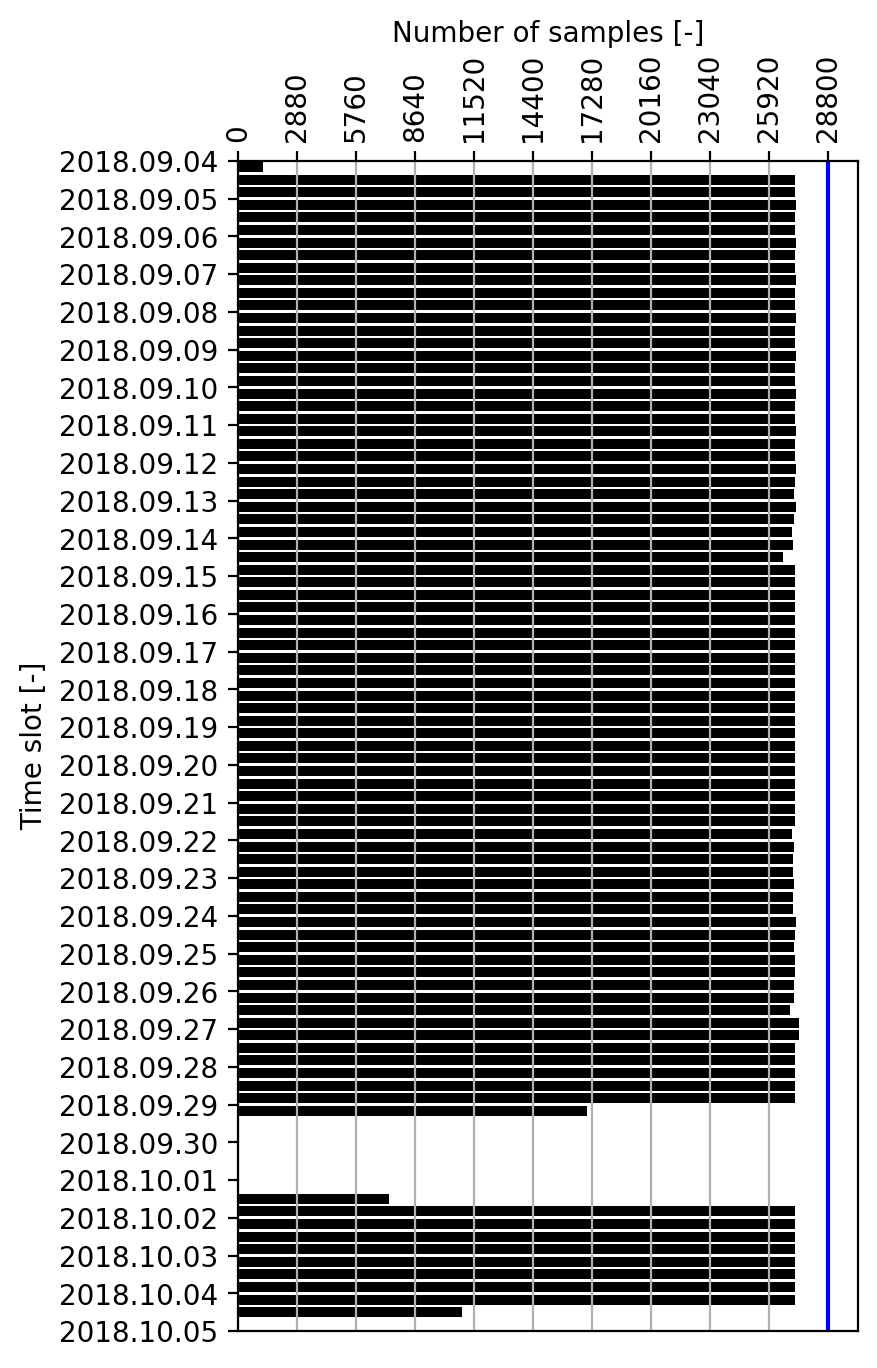

In [23]:
fig, ax = agg2.chartbar();

While the above plot is still manageable, it is does not scale to the complete data set, which contains about two years of data. A slightly better alternative is to produce a stem chart. The color scheme is the same (red for correct timestamps; black for correct checks throughout). Here we can see that time windows without any data are shown as a zero-valued point.

..\basic\visual.py:92: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(x[s],y[s], linefmt=colour[s+shift]+'-', markerfmt=colour[s+shift]+'.', basefmt='k-')


<Figure size 1550x800 with 0 Axes>

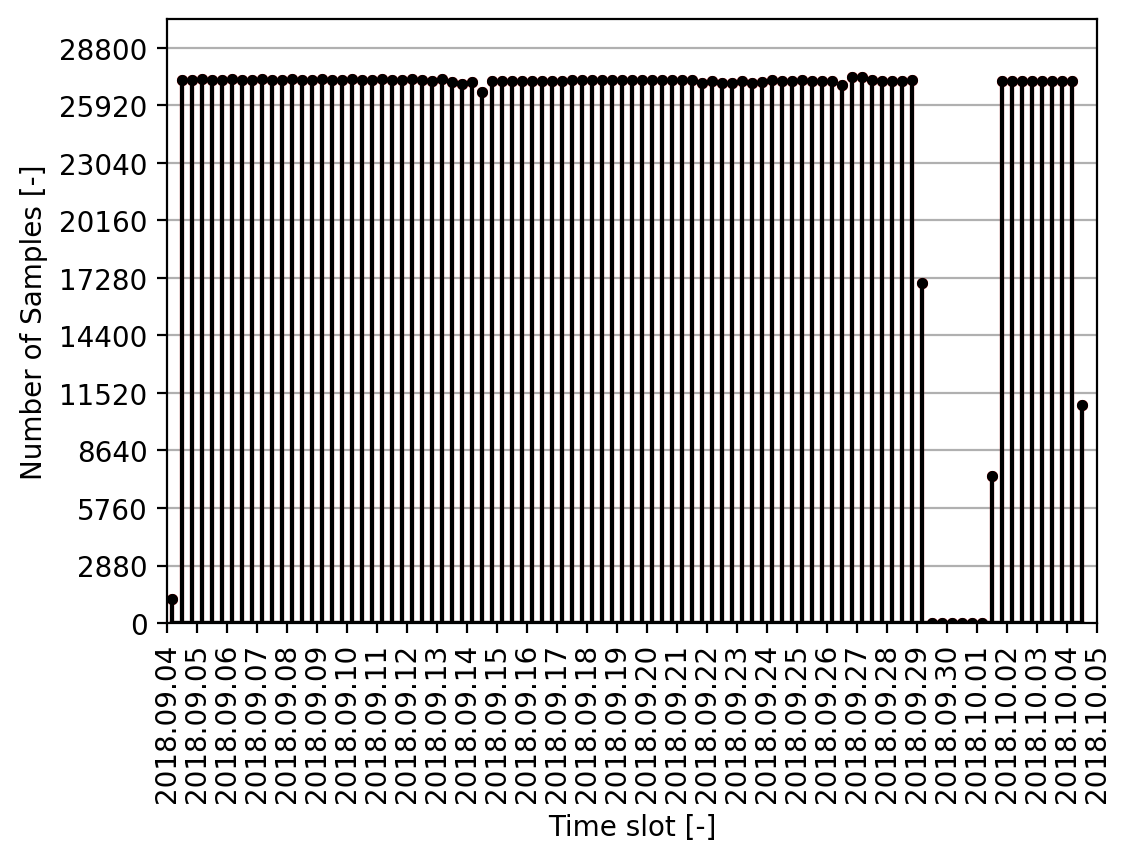

In [24]:
fig, ax = agg2.chartstem();

Even this plot will not scale very well for long time series. This is why a calendar heatmap is also useful. The next plot shows a heatmap of the number of samples with correct timestamp. Note that the calendar plot automatically sums the computed counts to counts per day, regardless of the original time window specification.

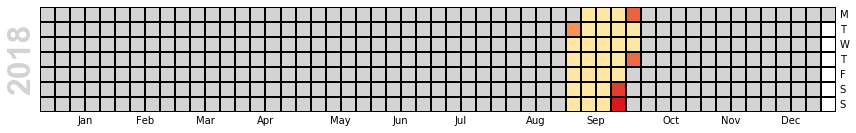

In [25]:
fig, ax = agg2.chartheat(mode='datetime');

The next plot show a similar heatmap for the ratio of the number of samples where all checks succeeded to the number of samples where only the datetime check succeeded. Days without any data are shown in grey. The last Sunday of September is an example of such a day. All reported ratios are 100%, meaning that there are no samples where only the timestamp check succeeds.

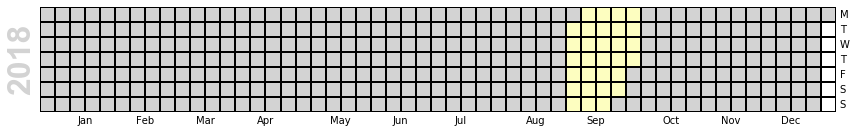

In [26]:
fig, ax = agg2.chartheat(mode='ratio')

Without any mode specification, the same feature displays the number of samples for which all checks succeed:

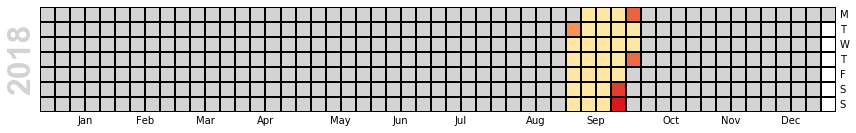

In [27]:
fig, ax = agg2.chartheat()

The next piece of code creates a new aggregation object, loops over all data files while aggregating the results, and then displays the counts of all samples where the datetime and all sensor readings are correct:

In [28]:
iDayStart = 0
iDayEnd = 731
TimeWindow = 8

from basic.production import aggregate
import os
agg3 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filepath)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)        
        
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number1 =  CheckNUM(NumberEntry=dfStrData['T1b'])
        CheckResult2 , Number2 =  CheckNUM(NumberEntry=dfStrData['T2b'])
        CheckResult3 , Number3 =  CheckNUM(NumberEntry=dfStrData['T3b'])
        CheckResult4 , Number4 =  CheckNUM(NumberEntry=dfStrData['T4b'])
        
        dfCheckDTNUMadd = pandas.DataFrame(columns=['DateTime','DateTimeCheck','CheckSenssorT1b','CheckSenssorT2b','CheckSenssorT3b','CheckSenssorT4b'])
        dfCheckDTNUMadd['DateTime'] = DateTime
        dfCheckDTNUMadd['DateTimeCheck'] = CheckResult0
        dfCheckDTNUMadd['CheckSenssorT1b'] = CheckResult1
        dfCheckDTNUMadd['CheckSenssorT2b'] = CheckResult2
        dfCheckDTNUMadd['CheckSenssorT3b'] = CheckResult3
        dfCheckDTNUMadd['CheckSenssorT4b'] = CheckResult4
        
        agg3(dfCheckDTNUMadd)
        

C:\G\data\sensorageing\potential_rowB\rowB_potential_day001.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day002.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day003.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day004.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day005.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day006.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day007.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day008.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day009.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day010.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day011.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day012.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day013.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day014.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day015.csv
C:\G\data\sensorageing\potential_rowB\ro

C:\G\data\sensorageing\potential_rowB\rowB_potential_day130.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day131.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day132.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day133.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day134.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day135.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day136.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day137.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day138.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day139.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day140.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day141.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day142.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day143.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day144.csv
C:\G\data\sensorageing\potential_rowB\ro

C:\G\data\sensorageing\potential_rowB\rowB_potential_day259.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day260.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day261.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day262.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day263.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day264.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day265.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day266.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day267.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day268.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day269.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day270.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day271.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day272.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day273.csv
C:\G\data\sensorageing\potential_rowB\ro

C:\G\data\sensorageing\potential_rowB\rowB_potential_day388.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day389.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day390.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day391.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day392.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day393.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day394.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day395.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day396.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day397.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day398.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day399.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day400.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day401.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day402.csv
C:\G\data\sensorageing\potential_rowB\ro

C:\G\data\sensorageing\potential_rowB\rowB_potential_day517.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day518.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day519.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day520.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day521.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day522.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day523.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day524.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day525.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day526.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day527.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day528.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day529.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day530.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day531.csv
C:\G\data\sensorageing\potential_rowB\ro

C:\G\data\sensorageing\potential_rowB\rowB_potential_day646.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day647.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day648.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day649.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day650.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day651.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day652.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day653.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day654.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day655.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day656.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day657.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day658.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day659.csv
C:\G\data\sensorageing\potential_rowB\rowB_potential_day660.csv
C:\G\data\sensorageing\potential_rowB\ro

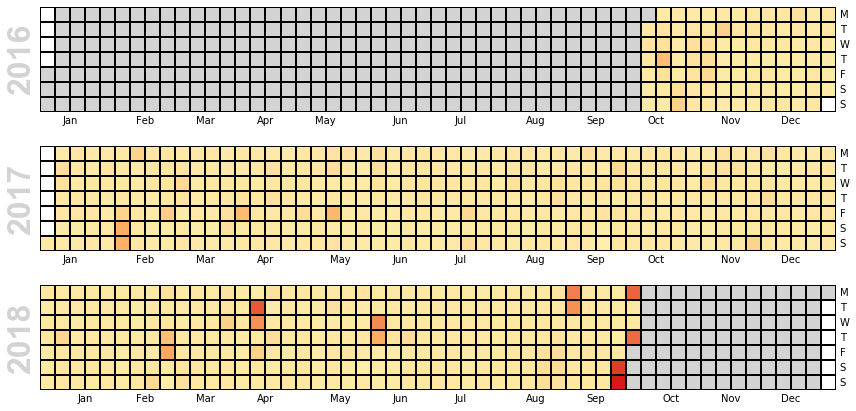

In [29]:
fig, ax = agg3.chartheat()
#fig, ax = agg3.chartheat(mode='ratio')

The graph indicates that the data productivity is fairly consistent throughout the experimental period. There are some exceptional days during 2018 however where the data productivity is remarkably low. 

# Take home message

The *AnomalyToolKit* enables to check the produced data volumes manually or automatically. We imagine two straightforward use cases:

* Producing and checking one of the plots produced above on a regular basis and plan of suitable maintenance actions when considered necessary.

* Setting a treshold for the minimum amount of data produced in a given time slot and generate an automated alarm when data productivity falls below this number. This is then followed by a visual inspection of the generated plots and the planning of suitable maintenance actions.